In [ ]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.data import AUTOTUNE
from tensorflow.keras import layers, models

In [ ]:
#Masks.zip upload to Runtime

#!gdown 1lJq1OcLTpUPdOEwV7zMD83f2w40wLVBQ -O "/content/Masks.zip"

In [ ]:
#Images.zip new links
!gdown --id 1WQ6jcCh8ZTGE-got_w3CpgeYGUeYPZkc -O /content/images.zip


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1WQ6jcCh8ZTGE-got_w3CpgeYGUeYPZkc
From (redirected): https://drive.google.com/uc?id=1WQ6jcCh8ZTGE-got_w3CpgeYGUeYPZkc&confirm=t&uuid=f2d9fbb4-1282-4d11-b4f0-3a116329c4c1
To: /content/images.zip
100% 5.34G/5.34G [01:42<00:00, 52.4MB/s]


In [ ]:
!gdown --id 1ZbGWDf0X-ftjiXpSQ8Dgn0qvkkFj1gTS -O /content/mask.zip


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ZbGWDf0X-ftjiXpSQ8Dgn0qvkkFj1gTS
To: /content/mask.zip
100% 9.57M/9.57M [00:00<00:00, 16.3MB/s]


In [ ]:
#Click on the code cell output actions button and Hide the output after running this cell
!unzip mask.zip

Archive:  mask.zip
   creating: Masks/
  inflating: Masks/image_2.png       
  inflating: Masks/image_3.png       
  inflating: Masks/image_10.png      
  inflating: Masks/image_13.png      
  inflating: Masks/image_14.png      
  inflating: Masks/image_16.png      
  inflating: Masks/image_18.png      
  inflating: Masks/image_19.png      
  inflating: Masks/image_21.png      
  inflating: Masks/image_26.png      
  inflating: Masks/image_28.png      
  inflating: Masks/image_34.png      
  inflating: Masks/image_37.png      
  inflating: Masks/image_40.png      
  inflating: Masks/image_41.png      
  inflating: Masks/image_43.png      
  inflating: Masks/image_44.png      
  inflating: Masks/image_45.png      
  inflating: Masks/image_52.png      
  inflating: Masks/image_60.png      
  inflating: Masks/image_67.png      
  inflating: Masks/image_68.png      
  inflating: Masks/image_73.png      
  inflating: Masks/image_75.png      
  inflating: Masks/image_80.png      
  inflating

In [ ]:
#Click on the code cell output actions button and Hide the output after running this cell
!unzip images.zip

Archive:  images.zip
   creating: Images/
  inflating: Images/image_1.jpg      
  inflating: Images/image_3.jpg      
  inflating: Images/image_6.jpg      
  inflating: Images/image_7.jpg      
  inflating: Images/image_9.jpg      
  inflating: Images/image_11.jpg     
  inflating: Images/image_22.jpg     
  inflating: Images/image_29.jpg     
  inflating: Images/image_44.jpg     
  inflating: Images/image_46.jpg     
  inflating: Images/image_51.jpg     
  inflating: Images/image_68.jpg     
  inflating: Images/image_53.jpg     
  inflating: Images/image_57.jpg     
  inflating: Images/image_67.jpg     
  inflating: Images/image_89.jpg     
  inflating: Images/image_72.jpg     
  inflating: Images/image_90.jpg     
  inflating: Images/image_86.jpg     
  inflating: Images/image_94.jpg     
  inflating: Images/image_95.jpg     
  inflating: Images/image_97.jpg     
  inflating: Images/image_101.jpg    
  inflating: Images/image_106.jpg    
  inflating: Images/image_107.jpg    
  inflat

In [ ]:
# Define paths
IMAGE_DIR = "/content/Images"
MASK_DIR = "/content/Masks"
IMG_SIZE = (256, 256)         # Resize images to this size
BATCH_SIZE = 32

In [ ]:
# Function to load and preprocess an image and its corresponding mask
def load_image(image_path, mask_path):
    image = load_img(image_path, target_size=IMG_SIZE)
    mask = load_img(mask_path, target_size=IMG_SIZE, color_mode="grayscale")

    image = img_to_array(image) / 255.0  # Normalize to [0,1]
    mask = img_to_array(mask) #In our IEEE dataset, the masks are already normalized
#     mask = img_to_array(mask) / 255.0    # Normalize mask

    return image, mask


In [ ]:
# Get image and mask file paths
image_files = sorted([os.path.join(IMAGE_DIR, fname) for fname in os.listdir(IMAGE_DIR)])
mask_files = sorted([os.path.join(MASK_DIR, fname) for fname in os.listdir(MASK_DIR)])


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch

# --- Custom Dataset ---
class FireDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [file for file in os.listdir(image_dir) if file.endswith('.jpg') or file.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '.png').replace('.jpeg', '.png'))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0).float()  # Binary mask

        return image, mask

# --- Transforms ---
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# --- Paths ---
image_dir = './Images'
mask_dir = './Masks'

# --- Create Dataset ---
dataset = FireDataset(image_dir, mask_dir, transform=transform)

# --- Split ---
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# --- DataLoaders ---
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)


In [ ]:
import torch.nn.functional as F

def weighted_bce_loss(output, target, weight=5):
    loss = F.binary_cross_entropy(output, target, reduction='none')
    weights = 1 + weight * target  # gives more weight to fire pixels
    return (loss * weights).mean()


In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)  # binary mask

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))

        bottleneck = self.bottleneck(self.pool2(enc2))

        dec2 = self.up2(bottleneck)
        dec2 = self.dec2(torch.cat([dec2, enc2], dim=1))

        dec1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([dec1, enc1], dim=1))

        return torch.sigmoid(self.final(dec1))  # output in [0, 1]


In [ ]:
def dice_coeff(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    target = target.float()

    smooth = 1e-6
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()

    return (2. * intersection + smooth) / (union + smooth)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Optionally use a learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

for epoch in range(10):
    model.train()

    train_loss_total = 0
    dice_total = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        # Compute weighted BCE loss
        loss = weighted_bce_loss(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_total += loss.item()

        # Calculate Dice coefficient for each batch and accumulate
        dice_total += dice_coeff(outputs, masks).item()

    # Validation
    model.eval()
    val_loss_total = 0
    dice_val_total = 0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            val_outputs = model(val_images)

            # Compute loss for validation
            val_loss = weighted_bce_loss(val_outputs, val_masks)
            val_loss_total += val_loss.item()

            # Calculate Dice coefficient for validation
            dice_val_total += dice_coeff(val_outputs, val_masks).item()

    # Calculate averages
    avg_train_loss = train_loss_total / len(train_loader)
    avg_dice_train = dice_total / len(train_loader)

    avg_val_loss = val_loss_total / len(val_loader)
    avg_dice_val = dice_val_total / len(val_loader)

    # Print statistics
    print(f"Epoch {epoch+1}:")
    print(f"  Training Loss: {avg_train_loss:.4f}")
    print(f"  Training Dice Coeff: {avg_dice_train:.4f}")
    print(f"  Validation Loss: {avg_val_loss:.4f}")
    print(f"  Validation Dice Coeff: {avg_dice_val:.4f}")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Step the scheduler if you're using it
    scheduler.step()

print("Training complete!")


Epoch 1:
  Training Loss: 0.1178
  Training Dice Coeff: 0.7176
  Validation Loss: 0.0362
  Validation Dice Coeff: 0.8112
  Learning Rate: 0.001000
Epoch 2:
  Training Loss: 0.0251
  Training Dice Coeff: 0.7878
  Validation Loss: 0.1263
  Validation Dice Coeff: 0.1574
  Learning Rate: 0.001000
Epoch 3:
  Training Loss: 0.0168
  Training Dice Coeff: 0.7938
  Validation Loss: 0.0118
  Validation Dice Coeff: 0.8237
  Learning Rate: 0.001000
Epoch 4:
  Training Loss: 0.0124
  Training Dice Coeff: 0.8156
  Validation Loss: 0.0104
  Validation Dice Coeff: 0.8306
  Learning Rate: 0.001000
Epoch 5:
  Training Loss: 0.0105
  Training Dice Coeff: 0.8254
  Validation Loss: 0.0093
  Validation Dice Coeff: 0.8529
  Learning Rate: 0.001000
Epoch 6:
  Training Loss: 0.0090
  Training Dice Coeff: 0.8398
  Validation Loss: 0.0083
  Validation Dice Coeff: 0.8522
  Learning Rate: 0.000500
Epoch 7:
  Training Loss: 0.0085
  Training Dice Coeff: 0.8463
  Validation Loss: 0.0078
  Validation Dice Coeff: 0.83

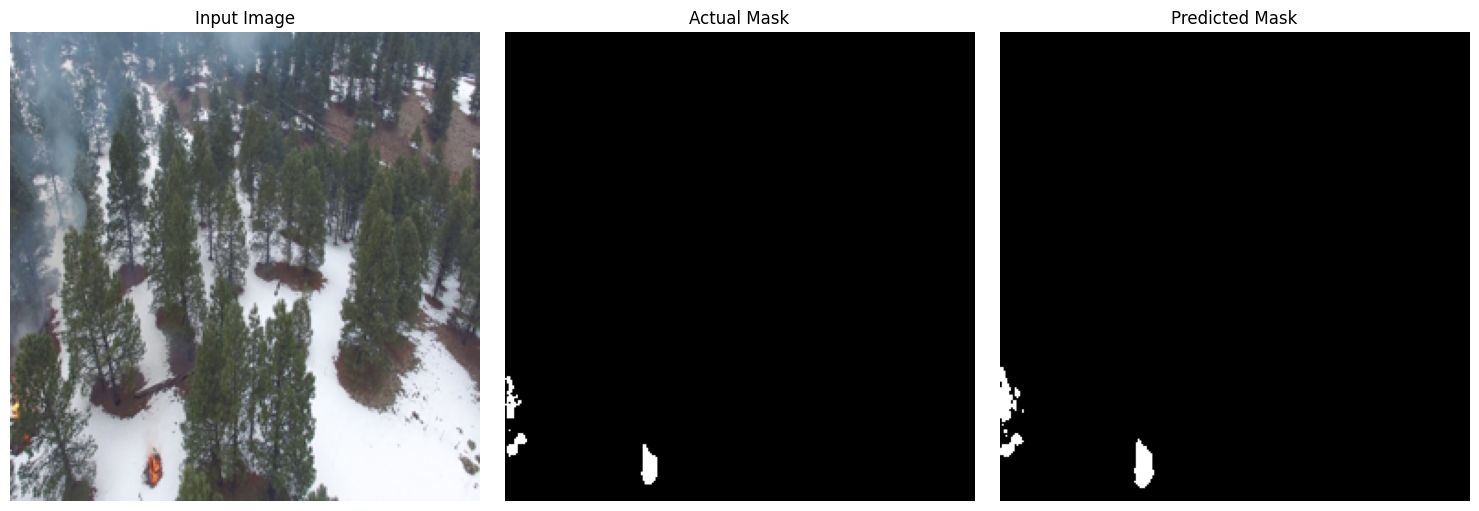

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

# --- Load a Random Image and its Corresponding Mask ---
image_path = os.path.join('./Images', os.listdir('./Images')[23])  # choose first or random image
mask_path = os.path.join('./Masks', os.listdir('./Images')[23].replace('.jpg', '.png').replace('.jpeg', '.png'))  # corresponding mask path

# Load image and mask
image = Image.open(image_path).convert("RGB")
actual_mask = Image.open(mask_path).convert("L")  # Grayscale mask

# --- Resize both the image and mask ---
image = image.resize((256, 256))
actual_mask = actual_mask.resize((256, 256))

# --- Define the transformation, including ToTensor ---
transform = transforms.ToTensor()

# Apply transformation to both image and mask
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
actual_mask_tensor = transform(actual_mask).unsqueeze(0).to(device)  # Grayscale mask

# --- Set model to eval mode ---
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    pred_mask = (output.squeeze().cpu().numpy() > 0.5).astype('uint8')

# --- Visualize ---
plt.figure(figsize=(15, 5))

# Input Image
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(image)
plt.axis('off')

# Actual Mask
plt.subplot(1, 3, 2)
plt.title("Actual Mask")
plt.imshow(actual_mask, cmap='gray')
plt.axis('off')

# Predicted Mask
plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import torch

# Ensure model is in evaluation mode
model.eval()

y_true = []
y_pred = []

inference_times = []

with torch.no_grad():  # Disable gradient computation
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        #print("Mask shape:", masks.shape)
        #print("Pred shape:", preds.shape)


        start = time.time()
        outputs = model(images)
        end = time.time()

        inference_times.append((end - start) / images.shape[0])  # Time per image

        # Apply sigmoid if it's a binary segmentation and threshold at 0.5
        #probs = torch.sigmoid(outputs)
        preds = (outputs > 0.3).int()  # Convert probabilities to binary predictions

        y_true.extend(masks.cpu().numpy().astype(np.uint8).flatten())
        y_pred.extend(preds.cpu().numpy().astype(np.uint8).flatten())

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute metrics
iou = np.sum((y_true & y_pred)) / np.sum((y_true | y_pred) + 1e-6)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
fpr = fp / (fp + tn + 1e-6)
fnr = fn / (fn + tp + 1e-6)
pixel_accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-6)
inference_speed_ms = np.mean(inference_times) * 1000  # in milliseconds

# Print results
print(f"IoU: {iou:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")
print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
print(f"Avg. Inference Speed: {inference_speed_ms:.2f} ms/image")


IoU: 0.6517
Precision: 0.6558
Recall: 0.9905
F1 Score: 0.7891
False Positive Rate (FPR): 0.0030
False Negative Rate (FNR): 0.0095
Pixel Accuracy: 0.9969
Avg. Inference Speed: 0.33 ms/image


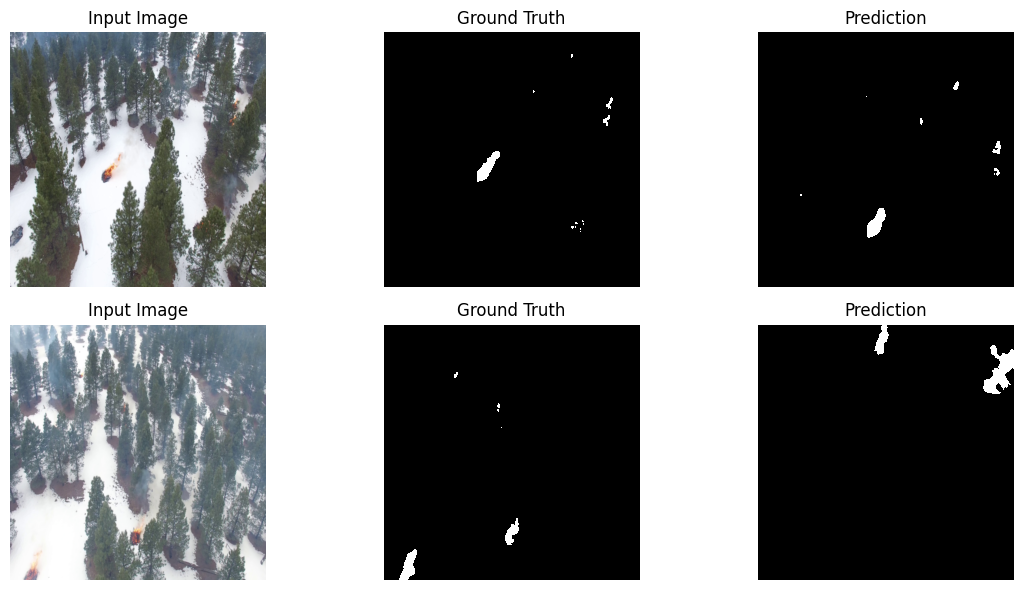

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_predictions(test_loader, model, device, num_images=5):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(12, num_images * 3))

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            output = model(input_tensor)
            pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()
            pred_mask = (pred_mask > 0.3).astype('uint8')  # try lower threshold


            for j in range(images.shape[0]):
                if images_shown >= num_images:
                    break

                # Move tensors to CPU and convert to numpy
                image_np = images[j].cpu().permute(1, 2, 0).numpy()
                mask_np = masks[j].cpu().squeeze().numpy()
                pred_np = preds[j].cpu().squeeze().numpy()

                # Plot input, ground truth, prediction
                plt.subplot(num_images, 3, images_shown * 3 + 1)
                plt.imshow(image_np)
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(num_images, 3, images_shown * 3 + 2)
                plt.imshow(mask_np, cmap="gray")
                plt.title("Ground Truth")
                plt.axis("off")

                plt.subplot(num_images, 3, images_shown * 3 + 3)
                plt.imshow(pred_np, cmap="gray")
                plt.title("Prediction")
                plt.axis("off")

                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()


visualize_predictions(test_loader, model, device, num_images=2)